# Trading Strategies powered by Machine Learning - Random Forest Classifier

## Data Processing

### Download data 

In [61]:
import sys
sys.path.append('../../')

In [62]:
from util.load_data import *
from config.constants import *
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [63]:
XAUUSD = load_data()

In [64]:
XAUUSD['D1']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604
2007-01-02,635.791,640.802,635.286,639.143,1282
2007-01-03,639.029,644.663,624.634,626.602,1302
2007-01-04,626.699,630.352,619.600,622.533,1365
2007-01-05,622.268,625.768,601.591,606.841,1284
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


In [65]:
df = XAUUSD['D1'].loc['2007':'2020']

### Add Feature

In [66]:
def get_rsi(df, rsi_period):
    chg = df['Close'].diff(1)
    gain = chg.mask(chg < 0, 0)
    loss = chg.mask(chg > 0, 0)
    avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    rs = abs(avg_gain/avg_loss)
    rsi = 100 - (100/(1+rs))
    return rsi

In [67]:
# relative strength index
df['rsi14'] = get_rsi(df, 14)

# moving averages
df['sma9'] = df['Close'].rolling(9).mean()
df['sma180'] = df['Close'].rolling(180).mean()
df['sma9_var'] = (df['Close']/df['sma9'])-1
df['sma180_var'] = (df['Close']/df['sma180'])-1

In [68]:
df

,Open,High,Low,Close,Volume,rsi14,sma9,sma180,sma9_var,sma180_var
Time,,,,,,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604,NaN,NaN,NaN,NaN,NaN
2007-01-02,635.791,640.802,635.286,639.143,1282,NaN,NaN,NaN,NaN,NaN
2007-01-03,639.029,644.663,624.634,626.602,1302,NaN,NaN,NaN,NaN,NaN
2007-01-04,626.699,630.352,619.600,622.533,1365,NaN,NaN,NaN,NaN,NaN
2007-01-05,622.268,625.768,601.591,606.841,1284,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1882.921,1889.208,1882.348,1888.098,59,59.723692,1877.180444,1870.509044,0.005816,0.009403
2020-12-28,1888.088,1900.098,1869.018,1876.605,1380,55.158228,1878.537111,1871.269600,-0.001029,0.002851
2020-12-29,1876.605,1886.278,1871.595,1878.658,1380,55.808090,1877.994111,1872.030822,0.000354,0.003540


In [69]:
df = df.dropna()

### Add Signal

In [70]:
df

,Open,High,Low,Close,Volume,rsi14,sma9,sma180,sma9_var,sma180_var
Time,,,,,,,,,,
2007-07-29,660.723,661.748,659.856,660.638,143,44.277086,673.647889,659.119572,-0.019313,0.002304
2007-07-30,660.889,665.498,659.476,664.975,1346,49.273715,672.392889,659.280861,-0.011032,0.008637
2007-07-31,665.045,668.644,662.708,663.438,1346,47.643242,670.226556,659.415833,-0.010129,0.006100
2007-08-01,663.438,667.347,658.353,664.895,1367,49.354097,668.279111,659.628572,-0.005064,0.007984
2007-08-02,665.148,666.919,662.122,665.128,1331,49.637515,666.434889,659.865211,-0.001961,0.007976
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1882.921,1889.208,1882.348,1888.098,59,59.723692,1877.180444,1870.509044,0.005816,0.009403
2020-12-28,1888.088,1900.098,1869.018,1876.605,1380,55.158228,1878.537111,1871.269600,-0.001029,0.002851
2020-12-29,1876.605,1886.278,1871.595,1878.658,1380,55.808090,1877.994111,1872.030822,0.000354,0.003540


In [71]:
df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))

In [72]:
df['signal_t1'] = np.sign(df.returns)

In [73]:
df

,Open,High,Low,Close,Volume,rsi14,sma9,sma180,sma9_var,sma180_var,returns,signal_t1
Time,,,,,,,,,,,,
2007-07-29,660.723,661.748,659.856,660.638,143,44.277086,673.647889,659.119572,-0.019313,0.002304,NaN,NaN
2007-07-30,660.889,665.498,659.476,664.975,1346,49.273715,672.392889,659.280861,-0.011032,0.008637,0.006543,1.0
2007-07-31,665.045,668.644,662.708,663.438,1346,47.643242,670.226556,659.415833,-0.010129,0.006100,-0.002314,-1.0
2007-08-01,663.438,667.347,658.353,664.895,1367,49.354097,668.279111,659.628572,-0.005064,0.007984,0.002194,1.0
2007-08-02,665.148,666.919,662.122,665.128,1331,49.637515,666.434889,659.865211,-0.001961,0.007976,0.000350,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1882.921,1889.208,1882.348,1888.098,59,59.723692,1877.180444,1870.509044,0.005816,0.009403,0.004764,1.0
2020-12-28,1888.088,1900.098,1869.018,1876.605,1380,55.158228,1878.537111,1871.269600,-0.001029,0.002851,-0.006106,-1.0
2020-12-29,1876.605,1886.278,1871.595,1878.658,1380,55.808090,1877.994111,1872.030822,0.000354,0.003540,0.001093,1.0


In [74]:
df['signal'] = df.signal_t1.shift(-1)

In [75]:
df

,Open,High,Low,Close,Volume,rsi14,sma9,sma180,sma9_var,sma180_var,returns,signal_t1,signal
Time,,,,,,,,,,,,,
2007-07-29,660.723,661.748,659.856,660.638,143,44.277086,673.647889,659.119572,-0.019313,0.002304,NaN,NaN,1.0
2007-07-30,660.889,665.498,659.476,664.975,1346,49.273715,672.392889,659.280861,-0.011032,0.008637,0.006543,1.0,-1.0
2007-07-31,665.045,668.644,662.708,663.438,1346,47.643242,670.226556,659.415833,-0.010129,0.006100,-0.002314,-1.0,1.0
2007-08-01,663.438,667.347,658.353,664.895,1367,49.354097,668.279111,659.628572,-0.005064,0.007984,0.002194,1.0,1.0
2007-08-02,665.148,666.919,662.122,665.128,1331,49.637515,666.434889,659.865211,-0.001961,0.007976,0.000350,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1882.921,1889.208,1882.348,1888.098,59,59.723692,1877.180444,1870.509044,0.005816,0.009403,0.004764,1.0,-1.0
2020-12-28,1888.088,1900.098,1869.018,1876.605,1380,55.158228,1878.537111,1871.269600,-0.001029,0.002851,-0.006106,-1.0,1.0
2020-12-29,1876.605,1886.278,1871.595,1878.658,1380,55.808090,1877.994111,1872.030822,0.000354,0.003540,0.001093,1.0,1.0


In [76]:
df = df.drop(columns=['returns','signal_t1'])

In [90]:
df = df.dropna()

In [91]:
df

,Open,High,Low,Close,Volume,rsi14,sma9,sma180,sma9_var,sma180_var,signal
Time,,,,,,,,,,,
2007-07-29,660.723,661.748,659.856,660.638,143,44.277086,673.647889,659.119572,-0.019313,0.002304,1.0
2007-07-30,660.889,665.498,659.476,664.975,1346,49.273715,672.392889,659.280861,-0.011032,0.008637,-1.0
2007-07-31,665.045,668.644,662.708,663.438,1346,47.643242,670.226556,659.415833,-0.010129,0.006100,1.0
2007-08-01,663.438,667.347,658.353,664.895,1367,49.354097,668.279111,659.628572,-0.005064,0.007984,1.0
2007-08-02,665.148,666.919,662.122,665.128,1331,49.637515,666.434889,659.865211,-0.001961,0.007976,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1872.528,1883.465,1869.378,1879.125,1125,57.152593,1873.197889,1869.623472,0.003164,0.005082,1.0
2020-12-27,1882.921,1889.208,1882.348,1888.098,59,59.723692,1877.180444,1870.509044,0.005816,0.009403,-1.0
2020-12-28,1888.088,1900.098,1869.018,1876.605,1380,55.158228,1878.537111,1871.269600,-0.001029,0.002851,1.0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4184 entries, 2007-07-29 to 2020-12-30
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4184 non-null   float64
 1   High        4184 non-null   float64
 2   Low         4184 non-null   float64
 3   Close       4184 non-null   float64
 4   Volume      4184 non-null   int64  
 5   rsi14       4184 non-null   float64
 6   sma9        4184 non-null   float64
 7   sma180      4184 non-null   float64
 8   sma9_var    4184 non-null   float64
 9   sma180_var  4184 non-null   float64
 10  signal      4184 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 392.2 KB


In [93]:
# Calculate value counts and percentages for the 'is_profit' column
value_counts = df['signal'].value_counts(normalize=True) * 100
print(value_counts)

 1.0    53.417782
-1.0    46.582218
Name: signal, dtype: float64


## Data Cleaning

## Model Building and Tuning

### Split into train and test set, separate the label

In [94]:
from sklearn.model_selection import train_test_split

# Split into train and test set
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Separate the label
y = train['signal'].copy()
X = train.drop(columns=['signal'])
y_test = test['signal'].copy()
X_test = test.drop(columns=['signal'])

### Scale all the continuous variables

roc_auc_score: 0.5200708007530521


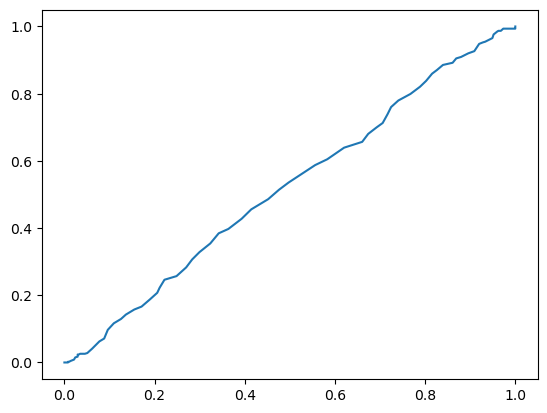

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fit baseline Random Forest classifier
model = RandomForestClassifier()
model.fit(X, y)

# Evaluate model on test data
y_test_pp = model.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test, y_test_pp[:, 1]))
fpr, tpr, thres = roc_curve(y_test, y_test_pp[:, 1])
ax = plt.plot(fpr, tpr)
plt.show()